# Appliance disaggregation

The following experiments directly tackle the appliance disaggregation problem, and the identification of  signal signatures of appliances in households.

### Generated Data

First, we propose to generate "toy data" of random signals with  the typical electric signal signature of a refrigerator:
- The time step of the time series is ** one second **
- The refrigerator is started each hours ($3600$ seconds) of one day ($24\times 3600$ seconds)
\begin{align}
\begin{cases}
0~W,~\mathrm{for ~}~ t < 0s \cup t>900s \\
200 \times (1+ \exp^{-\frac{t}{10}}) ~,\mathrm{otherwise}
\end{cases}
\end{align}

In [2]:
import numpy as np
import numpy.ma as ma
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd
from sklearn.cross_validation import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score, accuracy_score
%matplotlib inline

In [3]:
class Generator(object):
    @classmethod
    def gen_signals_hour(cls,zero=0):
        x = []
        for t in range(1,3601):
            if (t<0) or (t > 900):
                x.append(zero)
            else:
                x.append(200 * (1+ np.exp(-t/10)))
        return x
    
    @classmethod
    def gen_signature_day(cls,zero=0):
        x = []
        for h in range(24):
            x+=cls.gen_signals_hour(zero=zero)
        return x
    
    @classmethod
    def get_a(cls):
        x = np.zeros(3600*24)
        return x
    
    @classmethod
    def get_b(cls):
        return cls.get_a()+1000
    
    @classmethod
    def get_c(cls):
        x = []
        for h in range(24):
            for t in range(1, 3601):
                x.append(1000 * np.cos(2 * np.pi * (t / 3600.)))
        return np.array(x)
    @classmethod
    def get_d(cls):
        x = []
        for h in range(24):
            for t in range(1, 3601):
                x.append(0+ 15*np.random.rand())
        return np.array(x)
    @classmethod
    def get_e(cls):
        return cls.get_c() + cls.get_d()
    
    @classmethod
    def get_toy_dataset(cls):
        """
        based on previous data generator we propose to make a dataset of different hourly examples including:
        - signal+signature
        - signal alone
        500 hourly signal are generated of each aforementionned type of examples.        
        if noise== True, then 
        """
        df = pd.DataFrame()
        signature = cls.gen_signals_hour(zero=0)
        for i in range(500):
            x = cls.get_a()[:3600]
            df = df.append(pd.Series(x).T,ignore_index=True)
            x = cls.get_b()[:3600]
            df = df.append(pd.Series(x).T,ignore_index=True)
            x = cls.get_c()[:3600]
            df = df.append(pd.Series(x).T,ignore_index=True)
            x = cls.get_d()[:3600]
            df = df.append(pd.Series(x).T,ignore_index=True)
            x = cls.get_e()[:3600]
            df = df.append(pd.Series(x).T,ignore_index=True)
        dfsign = df.copy()+signature
        dfsign['label'] = 'refrigerator'
        df['label'] = 'mains'
        df = df.append(dfsign,ignore_index=True)
        df.to_csv('data/toy_dataset.csv',index=None)
        return df        

### Plot a random signal and the refrigerator signature
- plot the signal in blue
- the signature is in red

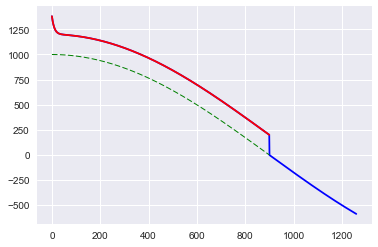

In [4]:
signal = Generator.get_c()
signature,signature_mask = np.array(Generator.gen_signature_day(zero=0)), np.array(Generator.gen_signature_day(zero=np.nan))
z = signal+signature
i =np.isnan(signature_mask)


minn = 0
maxx = 60
padding = 1200

#plot the electric signal + the refrigerator signature
sns.plt.plot(range(minn,maxx+padding),z[minn:maxx+padding],color='blue')

#plot the electric signal if there is the refrigerator
maska = ma.array(signal,mask=i,copy=True)
sns.plt.plot(range(minn,maxx+padding),maska[minn:maxx+padding],color='green',ls='--',lw=1,markevery=300,marker='x',)

#plot the refrigerator signature
mask = ma.array(z,mask=i,copy=True)
sns.plt.plot(range(minn,maxx+padding),mask[minn:maxx+padding],color='red')

### Reference Energy Disaggregation Data Set (REDD)[1]

While generating data is a good alternative for initial experiments, such usage remains limited to some preliminary experiments for testing algorithms. To prevent some misleading conclusions due to some misleading, it is strongly prefered to use some existing data:
- collected from rigourous simulations, for example with some system engineering tools like Simulink or Dymola.
- Collected from real measurements, with various sensors

REDD is a relatively large set of data collected from 20 different electricity appliances:* mains, oven, refrigerator, dishwaser, kitchen outlets, lighting, washer dryer, microwave, bathroom_gfi, electric_heat, stove, disposal, outlets_unknown, electronics, furance, smoke_alarms, air_conditioning, miscellaeneous, subpanel, outdoor_outlets *. Data are collected from 6 different households.


##### Use the dataset
For practical purposes, the original data are reorganized, as follows:
- Replace the timestamp (long int) to datetime object
- Slice each signal per hour.
- Create a new dataset with hourly separated data

<span style="color:red">Why slicing data?</span> In a traditional machine learning/ optimization where input dimension are fixed, it will require to have the same sample size when the model is put in production. Using hourly sub samples will reduce the overall number of input dimensions and may cope with some available samples in an operational context. This directly copes with the curse of dimensionality phenomena[2].
 
 
* <sub> [1] Kolter, J. Z., & Johnson, M. J. (2011, August). REDD: A public data set for energy disaggregation research. In Workshop on Data Mining Applications in Sustainability (SIGKDD), San Diego, CA (Vol. 25, pp. 59-62).</sub>
* <sub> [2] Keogh, E., & Mueen, A. (2011). Curse of dimensionality. In Encyclopedia of Machine Learning (pp. 257-258). Springer US. ISO 690<sub>


In [3]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
def mkdir(path):
    """check if a directory exists, otherwise create it"""
    if not os.path.exists(path):
        os.makedirs(path)
    return path

folder_root = mkdir('data')
file_types = os.path.join(folder_root, 'all_appliances.csv')
file_listfiles = os.path.join(folder_root, 'all_appliance_file.csv')

def get_all_redd_data():
    # Parse all building
    list_of_appliances = []
    df_all_file = pd.DataFrame()
    for building in range(1, 7):
        print('building ',building)
        filelabel = '/Users/nacimbelkhir/LUKO/low_freq/house_{b}/labels.dat'.format(b=building)
        dflabel = pd.read_csv(filelabel, header=None, names=['id', 'type'], index_col=None, delim_whitespace=True)

        # Parse All appliances
        for i, label in dflabel.iterrows():
            appliance_id = label.id
            appliance_type = label.type
            list_of_appliances.append(appliance_type)
            folder_appliance = mkdir(os.path.join(folder_root, 'meter_{0}'.format(appliance_type)))
            fileappliance = '/Users/nacimbelkhir/LUKO/redd_low_freq/building{building}/elec/meter{appliance}.csv'.format(
                building=building, appliance=appliance_id)

            df_meter = pd.read_csv(fileappliance, index_col=0, skiprows=3, header=None, names=['W'])
            df_meter.index = pd.to_datetime(df_meter.index, unit='s')
            groupmeters_hourly = df_meter.groupby(pd.TimeGrouper('H'))
            DF = pd.DataFrame()
            for i, df_hourly in groupmeters_hourly:

                tt = df_hourly.resample('S').bfill()
                vals = np.array(tt['W'])
                if len(vals) == 0:
                    pass
                else:
                    DF = DF.append(pd.Series(vals).T, ignore_index=True)

            filetrain = os.path.join(folder_appliance, 'train_b{0}_id{1}.csv'.format(building, appliance_id))
            infofile = pd.Series()
            infofile['type'] = appliance_type
            infofile['building'] = int(building)
            infofile['applianceid'] = int(appliance_id)
            infofile['file'] = filetrain
            df_all_file = df_all_file.append(infofile.T,ignore_index=True)
            DF.to_csv(filetrain)

    d = pd.DataFrame(list_of_appliances, columns=['type'])
    d.drop_duplicates(inplace=True)
    d.reset_index(drop=True, inplace=True)
    d.to_csv(file_types)
    df_all_file.building = df_all_file.building.astype(int)
    df_all_file.applianceid = df_all_file.applianceid.astype(int)
    df_all_file.to_csv(file_listfiles)

def create_dataset():
    """

    :return:
    """
    htrain = [1,2,3]
    meter= ['mains','refrigerator']

    all_file = pd.read_csv(file_listfiles,index_col=0)
    all_file = all_file.loc[ (all_file.building.isin(htrain)) & (all_file.type.isin(meter))]

    df = pd.DataFrame()
    for i, dataset_info in all_file.groupby('file'):
        ifile = dataset_info.file.unique()[0]
        appliancetype = dataset_info.type.unique()[0]
        print(ifile)
        tmpdf = pd.read_csv(ifile,index_col=0,skiprows=1,header=None)
        tmpdf = tmpdf.T.fillna(tmpdf.min(axis=1)).T
        tmpdf['label'] = appliancetype
        df = df.append(tmpdf,ignore_index=True)
    df.to_csv(file_dataset,index=None)

# A Statistical Machine Learning  Approach

We propose to use some classical machine learnings that are known to perform well on binary classification:
- Logistic Regression
- Support Vector Machine 
- Random Forest

Here, the two classes are: "mains" and "refrigerator"  and the data from REDD. A cross validation procedure with 15 resamples(preserving the proportion of the classes in Train and Set) is done, such that. 



In [4]:
from sklearn.svm import LinearSVC,SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import StratifiedShuffleSplit,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,jaccard_similarity_score
def xp_ml(datasetfile='data/toy_dataset.csv'):
    """

    :return:
    """
    df = pd.read_csv(datasetfile)
    df['label'].replace("mains", 0, inplace=True)
    df['label'].replace("refrigerator", 1, inplace=True)
    y = np.array(df['label'])
    del df['label']
    X= np.array(df)
    del df

    fold = StratifiedShuffleSplit(y=y,n_iter=15,test_size=0.3)
    i = 1
    try:
        dfml = pd.read_csv('score_ml.csv')
    except:
        dfml = pd.DataFrame()

    for ml in ["svm linear", "rf", "logistic"]:
        perf = []
        perf_jaccard = []
        for train_index, test_index in fold:
            xtrain, ytrain, xtest, ytest = X[train_index],  y[train_index],  X[test_index],  y[test_index]

            scale = MinMaxScaler()
            xtrain = scale.fit_transform(xtrain)

            if ml =='svm linear':
                estimator = LinearSVC()
            elif ml =='rf':
                estimator = RandomForestClassifier(n_estimators=20,n_jobs=4)
            elif ml == 'logistic':
                estimator = LogisticRegression(dual=True,n_jobs=4)
            else:
                raise ValueError('try one each these classifier: [ "svm linear", "rf", "logistic"]')

            estimator.fit(xtrain, ytrain)

            xtest = scale.transform(xtest)
            ypred = estimator.predict(xtest)
            perf.append(f1_score(ytest, ypred))
            perf_jaccard.append(jaccard_similarity_score(ytest, ypred))
        sperf = pd.Series(perf)
        sperf_jac = pd.Series(perf_jaccard)
        dfperf = pd.DataFrame()
        dfperf['f1'] = sperf.T
        dfperf['jaccard'] = sperf.T
        dfperf['algo'] = ml
        dfml = dfml.append(dfperf,ignore_index=True)
    dfml.to_csv('score_ml.csv',index=None)

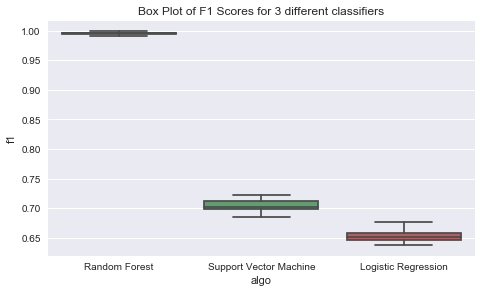

In [26]:
scoreml = pd.read_csv('score_ml.csv')
scoreml.replace('rf','Random Forest',inplace=True)
scoreml.replace('svm linear','Support Vector Machine',inplace=True)
scoreml.replace('logistic','Logistic Regression',inplace=True)

sns.factorplot(x="algo",y='f1',data=scoreml,kind="box",aspect=1.7)
sns.plt.title("Box Plot of F1 Scores for 3 different classifiers")

###  Multi Class Problem

We extend the first experiment to multiple classes: 'mains','refrigerator','microwave','dishwaser' of the REDD dataset. However, in addition to the binary classification experiments, a cross-validation procedure is performed on a dataset that includes the data of **3 households**  and followed by a validation procedure based on the data of ** 2 households** 

In [5]:
def create_dataset_larger():
    """

    :return:
    """
    def _train():
        print('make a new train set')
        htrain = [1,2,3]
        meter= ['mains','refrigerator','microwave','dishwaser']

        dict = {
            'mains':1,
            'refrigerator':2,
            'microwave':3,
            'dishwaser':4
        }

        all_file = pd.read_csv(file_listfiles,index_col=0)
        all_file = all_file.loc[ (all_file.building.isin(htrain)) & (all_file.type.isin(meter))]

        df = pd.DataFrame()
        for i, dataset_info in all_file.groupby('file'):
            ifile = dataset_info.file.unique()[0]
            appliancetype = dataset_info.type.unique()[0]
            print(ifile)
            tmpdf = pd.read_csv(ifile,index_col=0,skiprows=1,header=None)
            tmpdf = tmpdf.T.fillna(tmpdf.min(axis=1)).T
            tmpdf['label'] = appliancetype
            df = df.append(tmpdf,ignore_index=True)
        df.to_csv('data/redd_largerdataset_train.csv',index=None)

    _train()

    def _test():
        print('make a new test set')
        htrain = [4, 5]
        meter = ['mains', 'refrigerator', 'microwave', 'dishwaser']

        dict = {
            'mains': 1,
            'refrigerator': 2,
            'microwave': 3,
            'dishwaser': 4
        }

        all_file = pd.read_csv(file_listfiles, index_col=0)
        all_file = all_file.loc[(all_file.building.isin(htrain)) & (all_file.type.isin(meter))]

        df = pd.DataFrame()
        for i, dataset_info in all_file.groupby('file'):
            ifile = dataset_info.file.unique()[0]
            appliancetype = dataset_info.type.unique()[0]
            print(ifile)
            tmpdf = pd.read_csv(ifile, index_col=0, skiprows=1, header=None)
            tmpdf = tmpdf.T.fillna(tmpdf.min(axis=1)).T
            tmpdf['label'] = appliancetype
            df = df.append(tmpdf, ignore_index=True)
        df.to_csv('data/redd_largerdataset_test.csv', index=None)
    _test()

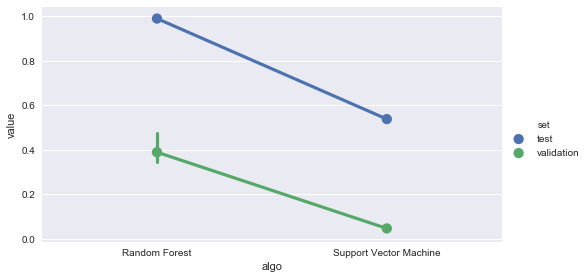

In [13]:
multiclass = pd.read_csv('score_ml_largerdataset_ml.csv')
multiclass.replace('rf','Random Forest',inplace=True)
multiclass.replace('svm linear','Support Vector Machine',inplace=True)
multiclass.replace('logistic','Logistic Regression',inplace=True)
sns.factorplot(x='algo',y='value',hue='set',data=multiclass,aspect=1.8)

# A Deep Learning Approach, Long Short Term Memory Recurrent Neural Network

LSTM are known to have outstanding performance when it is well tuned. Here we propose to use LSTM with simple parameters and only two hidden layers and sigmoid activation functions.


In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Convolution1D, LSTM, GlobalMaxPooling1D
from keras.utils import np_utils
from keras.callbacks import History
import gc

class ConvolutionalLSTM(object):
    def __init__(self, input_dim,
                 input_length,
                 nb_classes,
                 hidden_dims,
                 nb_filter=64,
                 filter_length=64,
                 batch_size=64,
                 pool_length=16,
                 nb_epoch=1):
        """

        :return:
        """
        self.history = History()
        self.batch_size = batch_size
        self.nb_epoch = nb_epoch
        self.input_dim = input_dim
        self.input_length = input_length

        self.model = Sequential()
        # self.model.add(Convolution1D(nb_filter=nb_filter, filter_length=filter_length, border_mode='same', activation='sigmoid',input_dim=input_dim))
        # self.model.add(MaxPooling1D())
        self.model.add(LSTM(input_dim=input_dim, output_dim=hidden_dims, return_sequences=True,dropout_U=0.3))
        self.model.add(LSTM(input_dim=input_dim, output_dim=hidden_dims, return_sequences=True,dropout_U=0.2))
        self.model.add(LSTM(input_dim=hidden_dims, output_dim=hidden_dims))

        self.model.add(Dense(input_dim=hidden_dims, output_dim=nb_classes, activation='sigmoid'))
        self.model.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer="adam")

    def fit(self, X_train, y_train, X_test, y_test):
        print('start fitting')
        X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
        X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

        return self.model.fit(X_train, y_train,
                              batch_size=self.batch_size,
                              nb_epoch=self.nb_epoch,
                              validation_data=(X_test, y_test), callbacks=[self.history])

    def predict(self, X_test, batchsize=32):
        X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
        return self.model.predict_classes(X_test, batch_size=batchsize)
    
    
class ConvolutionalNetwork1D(object):
    def __init__(self,
                 input_dim,
                 input_length,
                 nb_classes,
                 hidden_dims,
                 nb_filter=64,
                 filter_length=64,
                 batch_size=64,
                 pool_length=16,
                 nb_epoch=1):
        """
        :return:
        """
        self.history = History()
        self.batch_size = batch_size
        self.nb_epoch = nb_epoch
        self.input_dim = input_dim
        self.input_length = input_length

        self.model = Sequential()
        self.model.add(Convolution1D(nb_filter=nb_filter,
                                     filter_length=filter_length,
                                     border_mode='same',
                                     activation='sigmoid',
                                     # input_shape=(1,input_length,1)
                                     input_dim=input_dim,
                                     # input_length=input_length
                                     ))
        self.model.add(GlobalMaxPooling1D())

        self.model.add(Dense(hidden_dims))
        # self.model.add(Dropout(0.2))
        self.model.add(Activation('sigmoid'))
        self.model.add(Dense(hidden_dims))
        self.model.add(Activation('sigmoid'))
        self.model.add(Dense(hidden_dims / 2))
        self.model.add(Activation('sigmoid'))

        self.model.add(Dense(nb_classes, activation='sigmoid'))
        print('compiling')
        self.model.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer="adam")

    def fit(self, X_train, y_train, X_test, y_test):
        print('start fitting')
        X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
        X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

        return self.model.fit(X_train, y_train,
                              batch_size=self.batch_size,
                              nb_epoch=self.nb_epoch,
                              validation_data=(X_test, y_test), callbacks=[self.history])

    def predict(self, X_test, batchsize=32):
        X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
        return self.model.predict_classes(X_test, batch_size=batchsize)


Using TensorFlow backend.


In [7]:
dict_key = {
    'mains': 0,
    'refrigerator': 1,
    'microwave': 2,
    'dishwaser': 3
}
def _handle_zeros_in_scale(scale, copy=True):
    ''' Makes sure that whenever scale is zero, we handle it correctly.

    This happens in most scalers when we have constant features.'''

    # if we are fitting on 1D arrays, scale might be a scalar
    if np.isscalar(scale):
        if scale == .0:
            scale = 1.
        return scale
    elif isinstance(scale, np.ndarray):
        if copy:
            # New array to avoid side-effects
            scale = scale.copy()
        scale[scale == 0.0] = 1.0
        return scale
def scale(x, data_min, data_max, newmin=0, newmax=1):
    data_range = data_max - data_min
    scale_ = ((newmax - newmin) / _handle_zeros_in_scale(data_range))
    min_ = newmin - data_min * scale_
    x = x * scale_
    x += min_
    return x
def xp_largedataset_convolutionalNetwork():
    """
    :return:
    """
    df = pd.read_csv('data/redd_largerdataset_train.csv')
    df['label'].replace(dict_key, inplace=True)
    nb_classes = len(df['label'].unique())
    y = np.array(df['label'])

    del df['label']
    X = np.array(df)

    del df
    fold = StratifiedShuffleSplit(y=y, n_iter=1, test_size=0.4)
    try:
        dfml = pd.read_csv('score_larger_dataset_DL.csv')
    except:
        dfml = pd.DataFrame()

    dfvalidation = pd.read_csv('data/redd_largerdataset_test.csv')
    dfvalidation['label'].replace(dict_key, inplace=True)
    yval = np.array(dfvalidation['label'])
    del dfvalidation['label']
    xval = np.array(dfvalidation)

    dfplot_ALLXP = pd.DataFrame()
    for ml in [
        "convlstm",
        # "convnet",
    ]:
        iterindex = 1
        
        perf_test = []
        perf_validation = []
        for train_index, test_index in fold:
            xtrain, ytrain, xtest, ytest = X[train_index], y[train_index], X[test_index], y[test_index]

            ytrain = np_utils.to_categorical(ytrain, nb_classes=nb_classes)
            ytest = np_utils.to_categorical(ytest, nb_classes=nb_classes)

            minn = np.min(xtrain)
            maxx = np.max(xtrain)
            xtrain = scale(xtrain, minn, maxx, 0, 1)

            input_length, input_dim = xtrain.shape

            if ml == 'convnet':
                estimator = ConvolutionalNetwork1D(input_dim=input_dim, input_length=input_length,
                                                   nb_classes=nb_classes, hidden_dims=200, nb_epoch=30)
            elif ml == 'convlstm':
                estimator = ConvolutionalLSTM(input_dim=input_dim, input_length=input_length, nb_classes=nb_classes,
                                              hidden_dims=100, nb_epoch=30)
            else:
                raise ValueError('try one each these classifier: [ "svm linear", "rf", "logistic"]')


            xtest = scale(xtest, minn, maxx, 0, 1)

            estimator.fit(xtrain, ytrain, xtest, ytest)
            val_acc, val_loss, loss, acc = estimator.history.history['val_acc'], estimator.history.history['val_loss'], \
                                           estimator.history.history['loss'], estimator.history.history['acc']

            tmp = pd.DataFrame()
            d = pd.DataFrame()
            d['iter{0}'.format(iterindex)] = val_acc
            d['perf'] = 'Val Acc'
            tmp = tmp.append(d, ignore_index=True)

            d = pd.DataFrame()
            d['iter{0}'.format(iterindex)] = val_loss
            d['perf'] = 'Val Loss'
            tmp = tmp.append(d, ignore_index=True)

            d = pd.DataFrame()
            d['iter{0}'.format(iterindex)] = loss
            d['perf'] = 'Loss'
            tmp = tmp.append(d, ignore_index=True)

            d = pd.DataFrame()
            d['iter{0}'.format(iterindex)] = acc
            d['perf'] = 'Acc'
            tmp = tmp.append(d, ignore_index=True)

            dfplot_runs = dfplot_runs.append(tmp,ignore_index=True)

            xval = scale(xval, minn, maxx, 0, 1)
            ypred = estimator.predict(xval)
            print('The accuracy of the model on the Validation set is : {0}'.format(accuracy_score(list(yval), list(ypred))))
            perf_validation.append(accuracy_score(list(yval), list(ypred)))
            gc.collect()
            iterindex+=1

        dfplot_runs['algo'] = ml
        dfplot_ALLXP = dfplot_ALLXP.append(dfplot_runs,ignore_index=True)

        sperftest = pd.Series(perf_test)
        sperfval = pd.Series(perf_validation)

        dfperf = pd.DataFrame()
        dfperf['value'] = sperftest.T
        dfperf['set'] = 'test'
        dfperf['algo'] = ml
        dfml = dfml.append(dfperf, ignore_index=True)

        dfperf = pd.DataFrame()
        dfperf['value'] = sperfval.T
        dfperf['set'] = 'validation'
        dfperf['algo'] = ml
        dfml = dfml.append(dfperf, ignore_index=True)

    dfplot_ALLXP.to_csv('xpruns.csv',index=False)
    dfml.to_csv('score_larger_dataset_DL.csv', index=None)

The following figure show the learning process of one cross-validation, showing promising results of the model in particular with the 
![plot](plot1_convlstm.png)

Last  We validate the model when parsing a set of different shuffled signal  in the household 6 of the REDD dataset.


In [ ]:
import os
from sklearn.utils import shuffle
def mkdir(path):
    """
    Check if directories exist else it create all the dirs

    """
    if not os.path.exists(path):
        os.makedirs(path)
    return path

def _train():

    folder_root = mkdir('data')
    file_listfiles = os.path.join(folder_root, 'all_appliance_file.csv')

    print('make a new train set')
    htrain = [6]
    meter = ['mains', 'refrigerator', 'microwave', 'dishwaser']

    dict = {
        'mains': 1,
        'refrigerator': 2,
        'microwave': 3,
        'dishwaser': 4
    }

    all_file = pd.read_csv(file_listfiles, index_col=0)
    all_file = all_file.loc[(all_file.building.isin(htrain)) & (all_file.type.isin(meter))]
    all_file.drop_duplicates('type',inplace=True)
    print(all_file)
    df = pd.DataFrame()
    for i, dataset_info in all_file.groupby('file'):
        ifile = dataset_info.file.unique()[0]
        appliancetype = dataset_info.type.unique()[0]
        print(ifile)
        tmpdf = pd.read_csv(ifile, index_col=0, skiprows=1, header=None)
        tmpdf = tmpdf.T.fillna(tmpdf.min(axis=1)).T
        tmpdf = tmpdf.iloc[range(24)]
        tmpdf['label'] = appliancetype
        df = df.append(tmpdf, ignore_index=True)
    df = shuffle(shuffle(df))

    df_copy = df.copy()
    for col in df_copy.columns:
        df_copy[col] = df_copy['label']

    del df['label']
    del df_copy['label']
    df_copy.replace(dict,inplace=True)
    df = df.values.flatten()
    df_copy = df_copy.values.flatten()

    DF = pd.DataFrame()
    DF['value'] = df
    DF['label'] = df_copy
    print(DF)
    DF.to_csv('allbuilding6.csv')

In [13]:
def slidingWindow(sequence, winSize, step=1):
    """Returns a generator that will iterate through
    the defined chunks of input sequence.  Input sequence
    must be iterable."""

    # Verify the inputs
    try:
        it = iter(sequence)
    except TypeError:
        raise Exception("**ERROR** sequence must be iterable.")
    if not ((type(winSize) == type(0)) and (type(step) == type(0))):
        raise Exception("**ERROR** type(winSize) and type(step) must be int.")
    if step > winSize:
        raise Exception("**ERROR** step must not be larger than winSize.")
    if winSize > len(sequence):
        raise Exception("**ERROR** winSize must not be larger than sequence length.")

    # Pre-compute number of chunks to emit
    numOfChunks = ((len(sequence) - winSize) / step) + 1

    # Do the work
    for i in range(0, int(numOfChunks * step), step):
        yield sequence[i:i + winSize]





def valid():
    print('read file')
    df = pd.read_csv('data/redd_largerdataset_train.csv')
    df1 = pd.read_csv('data/redd_largerdataset_test.csv')
    df = df.append(df1, ignore_index=True)
    df.reset_index(drop=True, inplace=True)
    df.replace(dict_key, inplace=True)

    y = df['label']
    del df['label']
    x = np.array(df)

    minn = np.min(x)
    maxx = np.max(x)
    x = scale(x,minn,maxx,0,1)
    print(' Learn')
    estimator = RandomForestClassifier(n_estimators=50, n_jobs=4)
    #
    estimator.fit(x,y)

    validdf = pd.read_csv('allbuilding6.csv')
    chunk = slidingWindow(range(validdf.shape[0]),3600,3600)
    # i = 1
    # for c in chunk:
    #     print(i)
    #     i+=1
    # exit()
    xp = pd.DataFrame()
    print('start validation')
    a = 1
    for c in chunk:
        print(a)
        a+=1
        val = validdf.iloc[c].copy()
        xtest = list(val['value'])
        ytest = val['label'].unique()[0]
        y_pred = estimator.predict(scale(np.array(xtest).reshape(1,-1),minn,maxx))
        print(y_pred==ytest,end=', ')
        val['predlabel'] = y_pred[0]
        xp = xp.append(val,ignore_index=True)
    xp.to_csv('results2.csv')

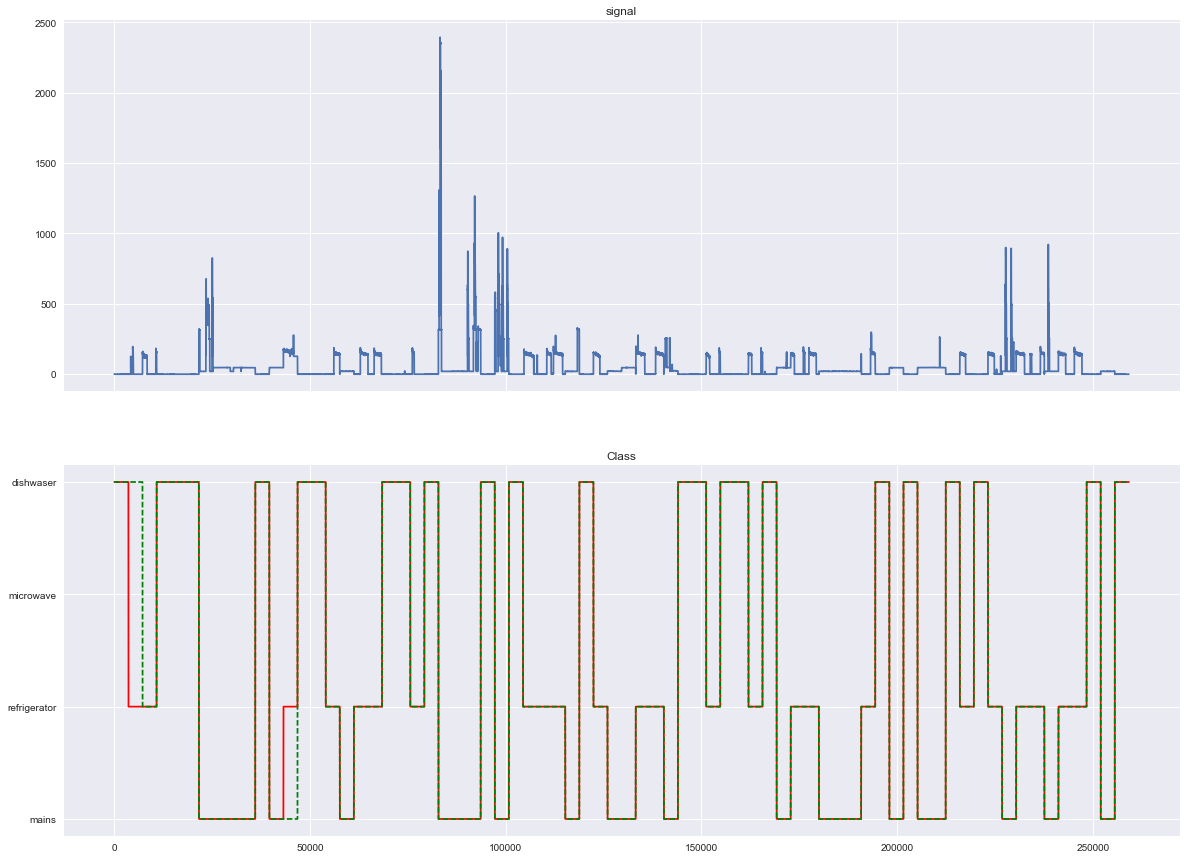

In [40]:
perf = pd.read_csv('results2.csv')
perf['predlabel'] = perf['predlabel']+1

dict_key = {
        1: 'mains',
        2: 'refrigerator',
        3: 'microwave',
        4: 'dishwaser'
    }
f, (ax1,ax2) = sns.plt.subplots(2, figsize=(20,15),sharex=True)
ax1.set_title('signal')
ax1.plot(perf['value'])


ax2.yaxis.set_ticks([1,2,3,4])
ax2.set_title('Class')
ax2.plot(perf['label'],c='red',label='True')
ax2.plot(perf['predlabel'],c='green',ls='--',label='Predicted')
ax2.set_yticklabels(['mains','refrigerator','microwave','dishwaser'])


For this last example we ramdomly generated 4 whole days(of 24 hours) randomly alterning 4 different signals of the households number 6 of the REDD database. Based on the dataset  5 different households.


The model is learned with a Random Forest classifier. For the validation, the 5 days signal is parsed with a 3600 seconds window with a 3600 step.


# Additionnal Questions


In [41]:
import numpy as np
import matplotlib.pyplot as plt
def exo1():
    def fact(n):
        if n<2:
            return 1
        else:
            return n*fact(n-1)
    print(fact(30))

def exo2():
    def sorted(x):
        i = np.argsort(x)
        y = np.asarray(x)[i]
        return y, i
    a = np.random.random_integers(-5,100,10)
    i,j = sorted(a)

def exo3():
    def min_tree(X, minn=np.inf):
        if np.isscalar(X):
            minn = X  if X <minn else minn
            return minn
        else:
            l = []
            for x in X:
                l.append(min_tree(x,minn=minn))
            return np.min(l)

    a = [[1,2,3], [1, 2, 3], [1,[[[[[[-1000]]]]]],  3], [[ [-100,   ],-1 ],100,40],1e4]
    min_tree(a)
